## **SNR validation for OSTEM**
---
#### Overview
- SSNR seems sensitive at short dwell times to streaking caused by scintillator. This means that part of the signal from one scanning position is carried on to the next scanning position due to the scintillator still decaying within the next dwell time. 
- Calculate spectral signal-to-noise ratio (SSNR) for images consisting of alternating scan rows, columns and horizontal and vertical lines
- Compare results to demonstrate differences in SSNR

- Also compute artificial streaking for longer dwell times, to demonstrate that the same effect appears. 
- Compute FFTs to demonstrate streaking effect on OSTEM images with short dwell times

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from skimage import img_as_float, img_as_ubyte, img_as_uint
from skimage.util import crop
from skimage import exposure
import tifffile as tf
import pandas as pd
import re
import seaborn as sns
import altair as alt
from tqdm.notebook import tqdm

In [2]:
#Local imports
import sys
# Add code directory to path
code_dir = '../code/'
if code_dir not in sys.path:
    sys.path.insert(1, code_dir)
# Import ssnr code
import ssnr
import noise

In [3]:
%config Completer.use_jedi = False
pd.set_option("display.max_rows", None)

## 1.1 Load all image data
---

In [107]:
# Find directory
DATA_dir = Path("../data/3_SNR-comparison-detectors/SNR-final-combined/HR")

# Select files and initialize DataFrame with image locations
df_im = pd.DataFrame({'FilePos': list(DATA_dir.glob('[!_]*/*.tif'))})

# Build up DataFrame
df_im['DetectionMode'] = df_im['FilePos'].apply(lambda x: x.parent.name)
df_im['LE'] = df_im['FilePos'].apply(lambda x: x.name.split('_')[1].split('kV')[0])
df_im['Dwell'] =  df_im['FilePos'].apply(lambda x: x.name.split('_')[2].split('ns')[0])

# List values in ascending order
df_im['Dwell'] = df_im['Dwell'].astype(float)
df_im = df_im.sort_values(['DetectionMode', 'Dwell'], ascending=[True, True])

# Preview
df_im.sort_values(['DetectionMode', 'LE'], inplace=True)
df_im.sample(10)

,FilePos,DetectionMode,LE,Dwell
132,..\data\3_SNR-comparison-detectors\SNR-final-c...,BSD-SB,1.5,200.0
7,..\data\3_SNR-comparison-detectors\SNR-final-c...,ADF-STEM,28,10000.0
127,..\data\3_SNR-comparison-detectors\SNR-final-c...,BSD-SB,1.5,100.0
225,..\data\3_SNR-comparison-detectors\SNR-final-c...,SE,1.5,3000.0
113,..\data\3_SNR-comparison-detectors\SNR-final-c...,BSD-SB,1.5,10000.0
76,..\data\3_SNR-comparison-detectors\SNR-final-c...,BSD,1.5,100.0
72,..\data\3_SNR-comparison-detectors\SNR-final-c...,BSD,1.5,1000.0
10,..\data\3_SNR-comparison-detectors\SNR-final-c...,ADF-STEM,28,10000.0
74,..\data\3_SNR-comparison-detectors\SNR-final-c...,BSD,1.5,1000.0
81,..\data\3_SNR-comparison-detectors\SNR-final-c...,BSD,1.5,100.0


## 1.2 Perform SSNR measurements
---

In [41]:
# Initialize DataFrame for SNR
df_snr = pd.DataFrame(columns=['DetectionMode', 'LE', 'Dwell', 'SSNR (normal)', 'SSNR (horizontal split)', 'SSNR (vertical split)', 'SNR (Joy)','SNR (Joy, horizontal split)'])

# Loop through bioimages
for i, row in tqdm(df_im.iterrows(), total=len(df_im)):

    # Load and crop images
    image = img_as_float(tf.imread(row['FilePos'].as_posix()))
        
    # Split images Compute SNR from SSNR
    images_normal = ssnr.split_image(image)
    images_horizontal_split = ssnr.split_image_cols(image)
    images_vertical_split = ssnr.split_image_rows(image)
    
    # Compute SNR from SSNR for differently split images
    snr_normal = ssnr.SSNR_full(images_normal)
    snr_horizontal = ssnr.SSNR_full(images_horizontal_split)
    snr_vertical = ssnr.SSNR_full(images_vertical_split)
    snr_joy = ssnr.SNR_JOY(image)
    snr_joy_horizontal_split = ssnr.SNR_JOY_horizontal_split(image)

    # Populate DataFrame
    df_snr.loc[i, 'DetectionMode'] = row['DetectionMode']
    df_snr.loc[i, 'LE'] = row['LE']
    df_snr.loc[i, 'Dwell'] = row['Dwell']
    df_snr.loc[i, 'SSNR (normal)'] = snr_normal
    df_snr.loc[i, 'SSNR (horizontal split)'] = snr_horizontal
    df_snr.loc[i, 'SSNR (vertical split)'] = snr_vertical
    df_snr.loc[i, 'SNR (Joy)'] = snr_joy
    df_snr.loc[i, 'SNR (Joy, horizontal split)'] = snr_joy_horizontal_split
    
    
# Preview
df_snr = df_snr.infer_objects()
df_snr.groupby('DetectionMode')\
      .apply(lambda x: x[::len(df_snr)//10])

  0%|          | 0/269 [00:00<?, ?it/s]

DetectionMode   LE    Dwell  SSNR (normal)  \
DetectionMode                                                  
ADF-STEM      24       ADF-STEM   28    100.0       4.368338   
              22       ADF-STEM   28   1000.0      18.543693   
              0        ADF-STEM   28  10000.0      32.108668   
BSD           76            BSD  1.5    100.0      -0.144299   
              71            BSD  1.5   1000.0       0.013573   
BSD-SB        125        BSD-SB  1.5    100.0      -0.139179   
              119        BSD-SB  1.5   1000.0       0.301440   
OSTEM         174         OSTEM    4    100.0       0.760229   
              185         OSTEM    4   3000.0       0.973269   
SE            214            SE  1.5    100.0       0.535245   
              225            SE  1.5   3000.0       1.081938   
_Qualitative  246  _Qualitative  1.5    100.0      -0.137611   

                   SSNR (horizontal split)  SSNR (vertical split)  SNR (Joy)  \
DetectionMode                                                                  
ADF-STEM      24                 67.741135               2.675275   2.808229   
              22                 55.591505              13.873538  13.561302   
              0                  38.254860              30.507996  20.946243   
BSD           76                 -0.337259               0.008968   0.051123   
              71                 -0.031674               0.036426   0.023423   
BSD-SB        125                -0.326327              -0.007550   0.011169   
              119                 0.333962               0.287259   0.283178   
OSTEM         174                17.355439               0.212256   0.205962   
              185                 1.082153               0.919882   0.815986   
SE            214                 1.488990               0.305244  14.667057   
              225                 1.235730               1.055522  15.511763   
_Qualitative  246                -0.325098               0.002993   0.025515   

                   SNR (Joy, horizontal split)  
DetectionMode                                   
ADF-STEM      24                     59.799581  
              22                     50.613665  
              0                      25.588754  
BSD           76                     -0.336933  
              71                     -0.042960  
BSD-SB        125                    -0.325992  
              119                     0.330313  
OSTEM         174                    16.690708  
              185                     0.970143  
SE            214                     1.211735  
              225                     0.900038  
_Qualitative  246                    -0.324823

In [42]:
# Save to csv to prevent running calculation again
df_snr.to_csv('snr_comparison.csv')

## 1.3 Plot comparison between detection methods
---

In [6]:
# (Optional) read csv with SNR values
snr_data = Path("../Notebooks/Supplementary/snr_comparison.csv")
df_snr = pd.read_csv(snr_data)

In [87]:
# Detection mode to plot
detection_mode = 'SE'
source = df_snr[df_snr['DetectionMode'] == detection_mode].copy()

# Calculate mean and std and build up dataframe
df_mean = source.groupby('Dwell')\
      .apply(lambda x: x.mean())
df_std = source.groupby('Dwell')\
      .apply(lambda x: x.std())
df_std.rename(columns = {'SSNR (normal)':'SSNR (normal) std','SSNR (horizontal split)':'SSNR (horizontal split) std',
                         'SSNR (vertical split)':'SSNR (vertical split) std','SNR (Joy)':'SNR (Joy) std', 
                         'SNR (Joy, horizontal split)':'SNR (Joy, horizontal split) std'}, inplace = True)
df_snr_complete = pd.concat([df_mean, df_std[['SSNR (normal) std','SSNR (horizontal split) std',
                            'SSNR (vertical split) std','SNR (Joy) std','SNR (Joy, horizontal split) std']]], axis=1)
df_snr_complete = df_snr_complete[df_snr_complete > 1e-5]
df_snr_complete

C:\Users\AJKIEV~1\AppData\Local\Temp/ipykernel_25256/2556719426.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  .apply(lambda x: x.mean())
C:\Users\AJKIEV~1\AppData\Local\Temp/ipykernel_25256/2556719426.py:9: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  .apply(lambda x: x.std())


,Dwell,SSNR (normal),SSNR (horizontal split),SSNR (vertical split),SNR (Joy),"SNR (Joy, horizontal split)",SSNR (normal) std,SSNR (horizontal split) std,SSNR (vertical split) std,SNR (Joy) std,"SNR (Joy, horizontal split) std"
Dwell,,,,,,,,,,,
100.0,100.0,0.572517,1.551194,0.336602,14.674804,1.233451,0.044243,0.073227,0.037376,0.026841,0.051866
200.0,200.0,0.437909,0.736895,0.345476,14.660977,0.573970,0.018686,0.022432,0.017527,0.014624,0.018323
300.0,300.0,0.422682,0.596485,0.367625,14.686521,0.476878,0.065491,0.074260,0.062525,0.044002,0.050643
500.0,500.0,0.790083,1.045003,0.721343,14.718439,0.531494,0.097143,0.109784,0.093241,0.036284,0.041576
1000.0,1000.0,0.474150,0.571138,0.445361,15.135352,0.493342,0.076646,0.081394,0.075600,0.047779,0.053454
3000.0,3000.0,1.345970,1.521527,1.315455,15.738464,1.143876,0.785193,0.848026,0.774589,0.669642,0.722943
5000.0,5000.0,2.597506,3.159899,2.482874,16.343809,2.033460,0.590829,0.685975,0.574345,0.339022,0.401555
10000.0,10000.0,3.748244,4.347187,3.754634,17.865885,3.504181,1.157633,1.310979,1.165015,1.403431,1.528305


In [88]:
from matplotlib.ticker import ScalarFormatter, FuncFormatter
import matplotlib.colors as mcolors
from matplotlib import cycler
import matplotlib as mpl

import matplotlib.ticker as plticker

In [89]:
bounds = {'OSTEM': [1e-1, 5e1],
          'BSD': [1e-4, 1e1],
          'BSD-SB': [1e-4, 5e1],
          'SE': [1e-1, 1e1],
          'ADF-STEM': [1e0, 5e2]
         }

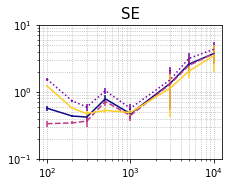

In [90]:
# Plot
source = df_snr_complete.copy()

# Pretty colormap
cmap = plt.get_cmap('plasma')
mpl.rcParams['axes.prop_cycle'] = cycler(color=cmap(np.linspace(0, 1.8, source.shape[1] - 2)))

# Figure and labels
snr_values = ['SSNR (normal)', 'SSNR (horizontal split)', 'SSNR (vertical split)', 'SNR (Joy)', 'SNR (Joy, horizontal split)']
fig, ax = plt.subplots(figsize=(3.3, 2.7)) # 4.5, 3.75 for OSTEM, 4.5, 3.5 for rest
fs = 15
linestyles = ['solid','dotted','dashed','dashdot','solid']

# Loop over calculated SNR values
for snr, style in zip(snr_values, linestyles):
    # plot
    source.plot(kind = 'line', x = 'Dwell', y = snr, yerr = f'{snr} std', linestyle=style, ax = ax)

# Aesthetics
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(bounds[detection_mode])
ax.grid(which='both', ls=':') 
ax.get_legend().remove()
ax.set(xlabel=None)
if detection_mode == 'OSTEM':
    ax.set_xlabel('Dwell', fontsize=fs)
    ax.set_ylabel('SNR', fontsize=fs)
    ax.legend(snr_values, loc='upper right', fontsize=fs-5) # fs - 5 for OSTEM, fs - 7 for rest
# ax.set_title(f"SNR for {source['DETECTION_MODE'].iloc[0]} as a function of dwell time for differently split images")
ax.set_title(f'{detection_mode}', fontsize=fs)
plt.tight_layout()
plt.savefig(f'SSNR_different_splits_{detection_mode}', dpi=300)

## 2. Effect of artificial streaking on SSNR
---
- We now deliberately introduce a bigger streaking contribution at longer dwell times, to see if this replicates the effect seen at lower dwell times

## 2.1 Plot images with different dwell time
---

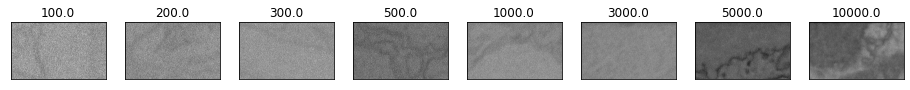

In [144]:
im_mode = df_im.loc[df_im['DETECTION_MODE'] == 'SE'].copy()

# Make figure (Dwell time varies by col)
ncols = im_mode['DWELL TIME (ns)'].unique().size
nrows = 1
fig, axes = plt.subplots(ncols=ncols, nrows=nrows,
                         sharex=False, sharey=True,
                         figsize=(2*ncols, 2*nrows))
axmap = {k: v for k, v in zip(im_mode['DWELL TIME (ns)'].unique(), axes.T)}
    
# Plot a random image per dwell time
for i, row in im_mode.groupby('DWELL TIME (ns)').apply(lambda x: x.sample(1)).iterrows():                      
    image = img_as_float(tf.imread(row['FilePos'].as_posix()))
    axmap[i[0]].imshow(image, cmap='Greys_r')
    axmap[i[0]].set_title(f"{row['DWELL TIME (ns)']}")
    axmap[i[0]].get_xaxis().set_visible(False)
    axmap[i[0]].get_yaxis().set_visible(False)

## 2.2 Plot short vs long dwell time image
---

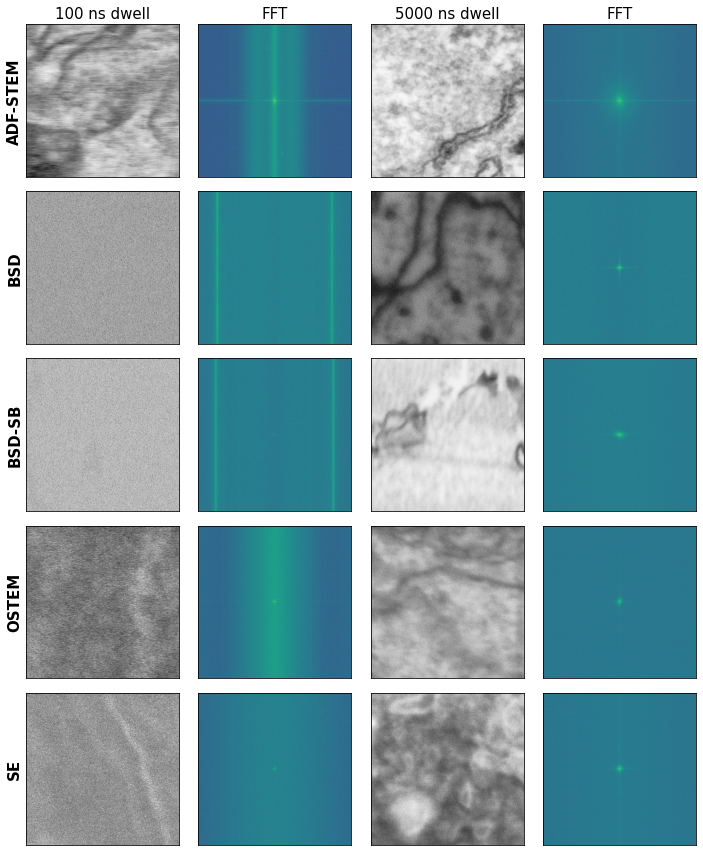

In [109]:
Dwell = ['100 ns', '5000 ns']
fs = 15
source = df_im.loc[(df_im['Dwell'].isin([100.0, 5000.0]))]\
               .groupby(by=["DetectionMode", "Dwell"])\
               .apply(lambda x: x.head(1))\
               .reset_index(drop=True)\
               .copy()

# Plot images and FFTs
nrows = len(df_im.DetectionMode.unique())
ncols = 4
fig, axes = plt.subplots(ncols=ncols, nrows=nrows,
                         sharex=True, sharey=True,
                         figsize=(2*nrows, 3*ncols))
plt.subplots_adjust(hspace=0.05)
plt.subplots_adjust(wspace=0.05)
axmap = {k: v for k, v in zip(source['DetectionMode'].unique(), axes)}

for MODE, grp in source.groupby("DetectionMode"):
    ax = axmap[MODE]

    for j, row in grp.apply(lambda x: x).reset_index().iterrows():
        i = (j+1) * 2
        # Calculate FFT
        im = tf.imread(row['FilePos'].as_posix())
        fft2 = np.fft.fft2(im[:920,:920])
        fft_shift = np.fft.fftshift(fft2)
        pow_s = abs(fft_shift)
        
        # Populate figure
        ax[i-2].imshow(im[:920,:920], cmap='Greys_r')
        ax[i-1].imshow(np.log(pow_s))
    
        # Axes aesthetics
        ax[i-1].get_xaxis().set_ticks([])
        ax[i-2].get_xaxis().set_ticks([])
        ax[i-1].get_yaxis().set_ticks([])
        ax[i-2].get_yaxis().set_ticks([])
        if MODE == 'ADF-STEM':
            ax[0].set_title(f"100 ns dwell", fontsize=fs)
            ax[1].set_title(f"FFT", fontsize=fs)
            ax[2].set_title(f"5000 ns dwell", fontsize=fs)
            ax[3].set_title(f"FFT", fontsize=fs)
    ax[0].set_ylabel(f'{MODE}', fontsize=fs, weight='bold')
# Save figure
plt.tight_layout()
plt.savefig(f"Dwell comparison", dpi=150)

## 2.3 Manipulate long dwell time image
---
- The streaking is modeled by using a single exponent decay function for YAG:ce, with a decay constant of 70ns
- The contribution of streaking is then similar to a convolution. For every pixel, the contributions of the last N pixels are added by a weighted sum. For example, for a 100ns dwell time, The first three weights are 0.1822, 0.04367 and 0.01047 respectively. 
- Moreover, noise is added to lower the SNR of the long dwell time image, before adding the streaking

In [1]:
# Define the intensity function and its primitive (normalized)
def intensity(t, tau=70):
    return np.exp(-t/tau) # tau = decay time
def F_intensity(t, tau=70):
    return -tau*np.exp(-t/tau)

In [2]:
# PLot the intensity function and determine the contributions for the first three pixels following the 
tau2 = 500
t = np.arange(0, 400, 1)
plt.plot(t, intensity(t, tau=tau2))
plt.ylabel('I')
plt.xlabel('t (ns)')
print(F_intensity(200, tau=tau2)-F_intensity(100, tau=tau2), 
      F_intensity(300, tau=tau2)-F_intensity(200, tau=tau2), F_intensity(400, tau=tau2)-F_intensity(300, tau=tau2))

NameError: name 'np' is not defined

In [3]:
# Define constants
dwell = 100 # dwell time of image in ns 
tau = 400 # decay constant ns
order = 25 # Amount of streaking to take into account (# pixels counted backwards)
kernel = np.ones(1)*1.0 # starting kernel
N = 5

# OSTEM images
image_long = img_as_uint(tf.imread(df_im.loc[203]['FilePos'].as_posix())) # 5000 ns
image_short = img_as_uint(tf.imread(df_im.loc[182]['FilePos'].as_posix())) # 100 ns
image_noisy = image_long + N*noise.white_noise(image_long.var(), image_long.shape) 

# Compute streaking kernel
for i in range(order):
    streaking = np.array([F_intensity((2+i)*dwell, tau)-F_intensity((1+i)*dwell, tau)])
    kernel = np.concatenate((kernel, streaking), axis=0)

# Flatten to 1D
im1d = image_long.flatten()
im1d_noisy = image_noisy.flatten()

# Compute streaked image
streaked1d = np.convolve(im1d, kernel, mode='same')
streaked_im = streaked1d.reshape(920, 1536)
noisy_streaked1d = np.convolve(im1d_noisy, kernel, mode='same')
noisy_streaked = noisy_streaked1d.reshape(920, 1536)

# Generate noisy streaked image
streaked_noisy = streaked_im + N*noise.white_noise(image_short.var(), image_short.shape) 

NameError: name 'np' is not defined

In [179]:
tf.imwrite('longdwell.tif', image_long)
tf.imwrite('shortdwell.tif', image_short)
tf.imwrite('streaked.tif', streaked_im)
tf.imwrite('noisy_streaked.tif', noisy_streaked)

## 2.4 Plot manipulated image
---

In [180]:
import matplotlib.colors as colors

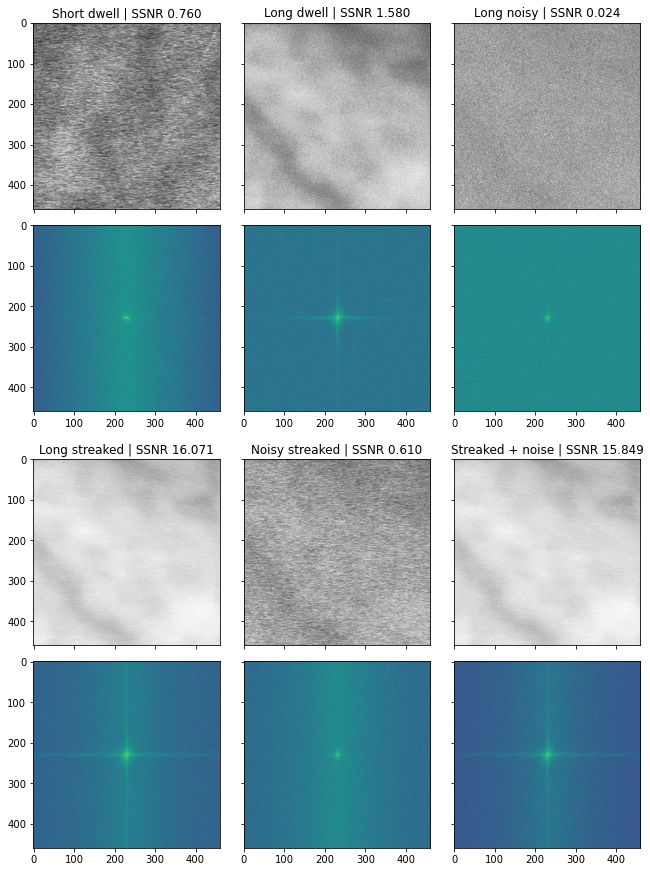

In [222]:
# Plot images and FFTs
fig = plt.figure(layout="constrained", figsize=(9, 12))
subfigs = fig.subfigures(2, 1)

images = [[image_short, image_long, image_noisy], 
          [streaked_im, noisy_streaked, streaked_noisy]]
titles = [['Short dwell', 'Long dwell', 'Long noisy'], 
         ['Long streaked', 'Noisy streaked', 'Streaked + noise']]

fs = 12
for subfig, images, titles_subset in zip(subfigs, images, titles):
    ax = subfig.subplots(2, 3, sharex=True, sharey=True)
    
    for i, (im, title) in enumerate(zip(images, titles_subset)):
    
        # Calculate FFT
        fft2 = np.fft.fft2(im[:920,616:])
        fft_shift = np.fft.fftshift(fft2)
        pow_s = np.abs(fft_shift)

        # Calculate SSNR
        split = ssnr.split_image(im)
        snr = ssnr.SSNR_full(split)

        ax[0][i].imshow(im[:920,616:], cmap='Greys_r')
        ax[0][i].set_title(f"{title} | SNR {snr:.3f}", fontsize=fs)
        ax[1][i].imshow(np.log(pow_s)[230:690,230:690])
        if i > 1:
            ax[1][i].imshow(np.log(pow_s)[230:690,230:690])
            
plt.savefig('3_Artificial_streaking_v2', dpi=150)

## 2.5 Plot manipulated images with range of tau values
---

In [7]:
dwell = 100 # ns
tau = [0, 0, 100, 200, 300, 400, 500] # ns, first two elements are placeholders for short and long dt images
order = 50 # Amount of streaking to take into account (# pixels counted backwards)
N = 5
images_original = [image_short, image_long]
title_original = ['100 ns image', '5000 ns image']

# Plot images and FFTs
fig, ax = plt.subplots(2, len(tau), figsize=(4.5*len(tau), 1.5*len(tau)))

for i, tau in enumerate(tau):
    
    if i < 2:
        im = images_original[i]
        title = title_original[i]
    else: 
        title = f'{tau} ns tau'
        # Streaked image
        image_noisy = image_long + N*noise.white_noise(image_long.var(), image_long.shape) 
    
        kernel = np.ones(1)*1.0 # starting kernel
        for j in range(order):
            streaking = np.array([F_intensity((2+j)*dwell, tau)-F_intensity((1+j)*dwell, tau)])
            kernel = np.concatenate((kernel, streaking), axis=0)
    
        im1d_noisy = image_noisy.flatten()
        noisy_streaked1d = np.convolve(im1d_noisy, kernel, mode='same')
        im = noisy_streaked1d.reshape(920, 1536)
    
    # Calculate FFT
    fft2 = np.fft.fft2(im[:920,616:])
    fft_shift = np.fft.fftshift(fft2)
    pow_s = np.abs(fft_shift)
    
    # Calculate SSNR
    split = ssnr.split_image(im)
    snr = ssnr.SSNR_full(split)
    
    ax[0][i].imshow(im[:920,616:], cmap='Greys_r')
    ax[0][i].set_title(f"{title} | SSNR {snr:.3f}", fontsize=14)
    ax[1][i].imshow(np.log(pow_s)[230:690,230:690])

plt.savefig('Streaking_different_tau', dpi=150)

NameError: name 'image_short' is not defined

## 2.6 'Destreak' short dwell time images
---
As artificial streaking can be introduced, we wondered whether the inverse transformation of streaked images was also possible

In [29]:
from scipy import signal
from numpy.fft import fft, ifft, ifftshift

In [30]:
def wiener_deconvolution(signal, kernel, lambd):
    "lambd is the SNR"
    kernel = np.hstack((kernel, np.zeros(len(signal) - len(kernel)))) # zero pad the kernel to same length
    H = fft(kernel)
    deconvolved = np.real(ifft(fft(signal)*np.conj(H)/(H*np.conj(H) + lambd**2)))
    return deconvolved

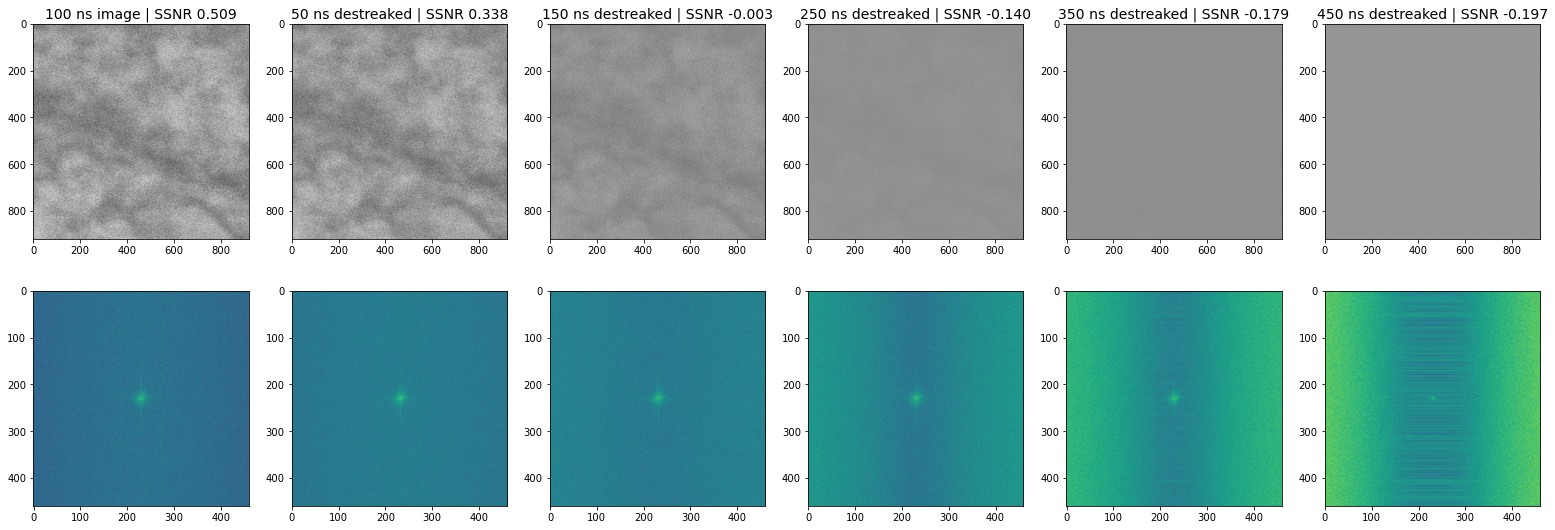

In [72]:
tau = [0, 50, 150, 250, 350, 450]
dwell = 100
order = 30 # Amount of streaking to take into account (# pixels counted backwards)
title = ['100 ns image', "100 ns image 'destreaked'"]
# image_short = img_as_uint(tf.imread(df_im.loc[113]['FilePos'].as_posix())) # 100 ns
image_short = img_as_uint(tf.imread(df_im.loc[135]['FilePos'].as_posix())) # 500 ns

# Calculate SSNR original image
split = ssnr.split_image(image_short)
snr_short = ssnr.SSNR_full(split)

# Plot images and FFTs
fig, ax = plt.subplots(2, len(tau), figsize=(4.5*len(tau), 1.5*len(tau)))

for i, tau in enumerate(tau):
    
    if i == 0:
        im = image_short
        title = '100 ns image'
    else: 
        title = f'{tau} ns destreaked'
        
        # Destreaked image
        kernel = np.ones(1)*1.0 # starting kernel
        for j in range(order):
            streaking = np.array([F_intensity((2+j)*dwell, tau)-F_intensity((1+j)*dwell, tau)])
            kernel = np.concatenate((kernel, streaking), axis=0)
        im1d = im.flatten()
        im = wiener_deconvolution(im1d, kernel, 1/snr_short) # Destreaked
        im = im.reshape(920, 1536)
    
    # Calculate FFT
    fft2 = np.fft.fft2(im[:920,:920])
    fft_shift = np.fft.fftshift(fft2)
    pow_s = np.abs(fft_shift)
    
    # Calculate SSNR
    split = ssnr.split_image(im)
    snr = ssnr.SSNR_full(split)
    
    ax[0][i].imshow(im[:920,616:], cmap='Greys_r')
    ax[0][i].set_title(f"{title} | SSNR {snr:.3f}", fontsize=14)
    ax[1][i].imshow(np.log(pow_s)[230:690,230:690])
    
    tf.imsave(f"{tau}ns_destreaked.tif", im)

plt.savefig('destreaking_different_tau', dpi=150)